In [1]:
# Importing all the necessary libraries for the notebook

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Section A: 

In [2]:
def load_images_and_masks(images_path="apples/*.jpg", masks_path="apples/*.png"):
    """
    This function loads and preprocesses color images and their corresponding mask images

    INPUT:
    images_path     : String path to locate color images
    masks_path      : String path to locate mask images

    OUTPUT:
    color_images    : List of numpy arrays conatining normalised color images
    mask_images     : List of numpy arrays conatining binary mask images
    """
    color_images = []
    mask_images = []

    # We locate all color image and mask files
    color_files = glob.glob(images_path)
    mask_files = glob.glob(masks_path)

    # We load and normalise the color images
    for color_file in color_files:
        img = plt.imread(color_file)
        if img.dtype == np.uint8:
            img = img.astype(np.float32) / 255.0  
        color_images.append(img)

    # We load and threshold the mask images
    for mask_file in mask_files:
        mask = plt.imread(mask_file)
        if mask.ndim == 3:
            # Averaging across the RGB to use as our threshold for conversion to binary
            mask = np.mean(mask, axis=2)
        binary_mask = (mask > 0.5).astype(np.uint8)
        mask_images.append(binary_mask)
    return color_images, mask_images

def plot_images_masks(color_images, mask_images, num_samples=5):
    """
    This function plots a specified number of image-mask pairs

    INPUT:
    color_images    : List of numpy arrays conatining normalised color images
    mask_images     : List of numpy arrays conatining binary mask images
    num_samples     : Integer number of samples to display
    """
    num_samples = min(num_samples, len(color_images), len(mask_images))
    for i in range(num_samples):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(color_images[i])
        axes[0].set_title('Color Image')
        axes[1].imshow(mask_images[i], cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        for ax in axes:
            ax.axis('off')
        plt.show()

def load_ground_truth_mask(mask_path):
    """
    This function loads and preprocesses the ground-truth mask for the test images

    INPUT:
    masks_path      : String path to locate mask images

    OUTPUT:
    ground_truth    : Numpy array containing the binary mask
    """
    mask = plt.imread(mask_path)
    if mask.ndim == 3:
        mask = np.mean(mask, axis=2)
    binary_mask = (mask > 0.5).astype(np.uint8)
    return binary_mask



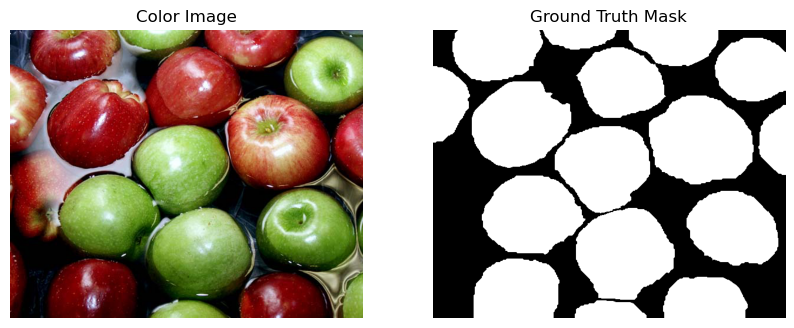

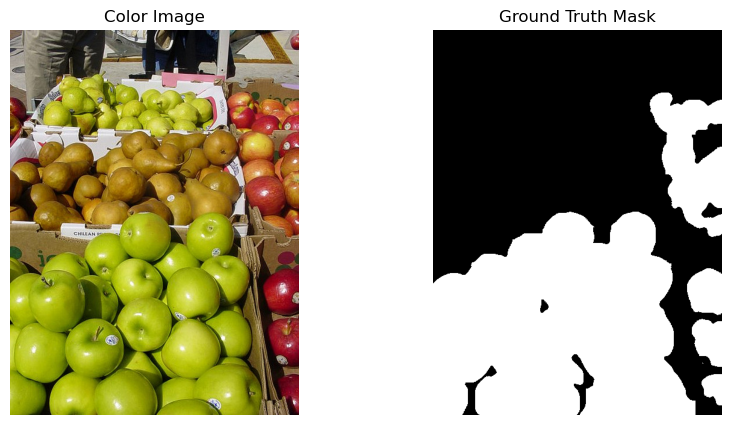

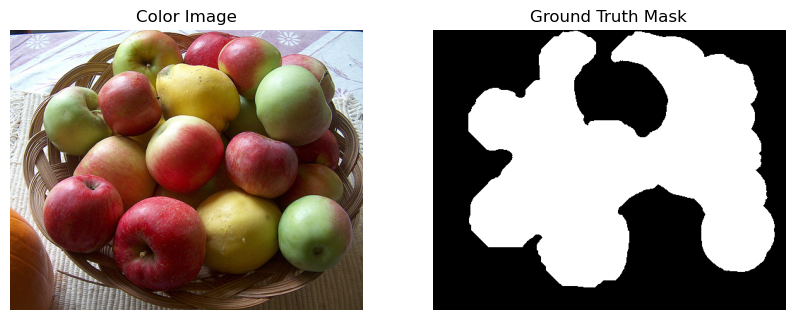

In [3]:
training_images_path = "apples/*.jpg"
training_masks_path = "apples/*.png"

color_images_train, mask_images_train = load_images_and_masks(training_images_path, training_masks_path)
plot_images_masks(color_images_train, mask_images_train, num_samples=3)


# Section B: 

In [4]:
def extract_pixels(color_images, mask_images):
    """
    This function extracts apple and non-apple pixels based on the masks

    INPUT:
    color_images    : List of numpy arrays conatining normalised color images
    mask_images     : List of numpy arrays conatining binary mask images

    OUTPUT:
    apple_pixels    : Numpy array of apple pixels, Shape: (nDims, num_apple_pixels)
    non_apple_pixels: Numpy array of non-apple pixels, Shape: (nDims, num_non_apple_pixels)
    """
    apple_pixels_list = []
    non_apple_pixels_list = []

    for idx in range(len(mask_images)):
        mask = mask_images[idx]
        img = color_images[idx]

        # We reshape the images to use vector operations
        pixels = img.reshape(-1, img.shape[2]).T  
        masks = mask.flatten() 

        apple_pixels_list.append(pixels[:, masks == 1])
        non_apple_pixels_list.append(pixels[:, masks == 0])

        apple_pixels = np.hstack(apple_pixels_list)  
        non_apple_pixels = np.hstack(non_apple_pixels_list)  

    return apple_pixels, non_apple_pixels

def getProbabilityGauss(data, gaussMean, gaussCov):
    """
    This function lets us calculate the probability density of data under a Gaussian distribution

    INPUT: 
    data        : Numpy array containing data points, Shape: (nDims, nData)
    gaussMean   : Numpy array containing the mean of the Gaussian, Shape: (nDims,)
    gaussCov    : Numpy array containing the covariance matrix of the Gaussian, Shape: (nDims, nDims)

    OUTPUT: 
    like        : Numpy array containing the Ppobability densities, Shape: (nData,)
    """
    exponent = -0.5 * np.sum((data - gaussMean[:, np.newaxis]) * ((np.linalg.pinv(gaussCov)) @ (data - gaussMean[:, np.newaxis])), axis=0) 
    # I've added the small constant for numerical stability
    denominator = np.sqrt((2 * np.pi) ** 3 * np.linalg.det(gaussCov) + 1e-10)
    like = np.exp(exponent) / denominator
    return like

def getMixGaussLogLike(data, mixGaussEst):
    """
    This function calculates the log-likelihood of the data under the mixture of Gaussian

    INPUT:
    data        : Numpy array containing data points, Shape: (nDims, nData)
    mixGaussEst : Dictionary containing the current estimates of the MoG (Mixture of Gaussian) parameters

    OUTPUT:
    Like        : Log-likelihood scalar
    """
    _, nData = data.shape
    likelihood = np.zeros(nData)
    for k in range(mixGaussEst['k']):
        likelihood += mixGaussEst['weight'][k] * getProbabilityGauss(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
        log_likelihood = np.sum(np.log(likelihood + 1e-10)) 
    return log_likelihood

def getMixGaussLike(data, mixGaussEst):
    """
    This function calculates the probability of data with our Mixture of Gaussians model 

    INPUT:
    data        : Numpy array containig the data points 
    mixGaussEst : Dictionary containing the current estimates of the MoG (Mixture of Gaussian) parameters

    OUTPUT:
    prob        : Numpy array containing the probability densities
    """
    _, nData = data.shape
    likelihood = np.zeros(nData)
    for k in range(mixGaussEst['k']):
        likelihood += mixGaussEst['weight'][k] * getProbabilityGauss(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
    return likelihood

def fitMixGauss(data, k, nIter=150, eps=1e-4):
    """
    This function fits a Gaussian Mixture Model to the data using the EM algorithm

    INPUT:
    data        : Numpy array containing data points, Shape: (nDims, nData)
    k           : Integer showing the number of Gaussian components
    nIter       : Integer showing the maximum number of iterations
    eps         : Float espilon, which is a small constant representing the criterion for convergence

    OUTPUT:
    mixGaussEst : Dictionary containing the current estimates of the MoG (Mixture of Gaussian) mixGaussEst
    log_Like    : List containing the log-likelihood values over iterations
    """
    num_dims, num_points = data.shape

    # We initialise mixGaussEst for the Gaussian Mixture Model
    mixGaussEst = {
        'd': num_dims,
        'k': k,
        'weight': (1 / k) * np.ones(k),
        'mean': np.random.randn(num_dims, k),
        'cov': np.array([np.eye(num_dims) for _ in range(k)]) 
    }

    log_likelihood = []
    initial_ll = getMixGaussLogLike(data, mixGaussEst)
    log_likelihood.append(initial_ll)

    for iteration in range(nIter):
        # E-Step: We calculate the responsibilities
        resp = np.zeros((k, num_points))
        for idx in range(k):
            resp[idx] = mixGaussEst['weight'][idx] * getProbabilityGauss(
                data,
                mixGaussEst['mean'][:, idx],
                mixGaussEst['cov'][:, :, idx]
            )
        # I have added a small constant for numerical stability
        resp_sum = np.sum(resp, axis=0) + 1e-10 
        resp /= resp_sum

        # M-Step: We update mixGaussEst based on responsibilities
        Nk = np.sum(resp, axis=1)  
        mixGaussEst['weights'] = Nk / num_points

        for idx in range(k):
            mixGaussEst['mean'][:, idx] = (data @ resp[idx, :]) / Nk[idx]
            diff = data - mixGaussEst['mean'][:, idx, np.newaxis]
            mixGaussEst['cov'][:, :, idx] = (diff * resp[idx, :]) @ diff.T / Nk[idx]
            mixGaussEst['cov'][:, :, idx] += 1e-6 * np.eye(num_dims)

        # We compute and store log-likelihood
        current_ll = getMixGaussLogLike(data, mixGaussEst)
        log_likelihood.append(current_ll)

        # This is our criteria for convergence
        if abs(log_likelihood[-1] - log_likelihood[-2]) < eps:
            print(f"The log likelihood converged at iteration {iteration + 1}")
            break
    else:
        print("The EM algorithm reached the maximum number of iterations without the log likelihood converging")

    return mixGaussEst, log_likelihood




In [5]:
apple_pixels, non_apple_pixels = extract_pixels(color_images_train, mask_images_train)

k_components = 3  
gmm_apple, apple_log_like = fitMixGauss(apple_pixels, k=k_components)
gmm_non_apple, nonApple_log_like = fitMixGauss(non_apple_pixels, k=k_components)

The EM algorithm reached the maximum number of iterations without the log likelihood converging
The EM algorithm reached the maximum number of iterations without the log likelihood converging


### Decisions made in this section: 

Choice of number of mixture components: After having changed it to a few values, I chose to set the number of mixture components to 3. If we set this number too high, we run the risk of overfitting to the training data, and if it is too low, we mihgt underfit and have a very poor model. 

Choice of number of iteration: I chose the maximum number of iterations to be 150 just in case, as I have run a the code a couple times whithout the apple or non apple GMM reaching the convergence criteria. 

Choice of the EM algorithm: I chose to use a similar structure to the one we use in the practical part C because the problems seem similar in structure. 

# Section C: 

In [6]:
def predict_posterior(image, gmm_apple, gmm_non_apple, prior_apple=0.4, prior_non_apple=0.6):
    """
    This function predicts the posterior probability of each pixel being an apple

    INPUT:
    image               : Numpy array containing the input color image
    gmm_apple           : Dictionary conatininng the trained model parameters for apple pixels
    gmm_non_apple       : Dictionary conatininng the trained model parameters for non-apple pixels
    prior_apple         : Float prior probability of a pixel being an apple
    prior_non_apple     : Float prior probability of a pixel being a non-apple

    OUTPUT:
    posterior_map       : Numpy array containing the posterior probability map 
    """

    pixels = image.reshape(-1, image.shape[2]).T 

    # We compute P(x|apple) and P(x|non-apple)
    px_apple = getMixGaussLike(pixels, gmm_apple) 
    px_non_apple = getMixGaussLike(pixels, gmm_non_apple) 

    # We compute posterior probabilities using Bayes' Theorem
    posterior = (px_apple * prior_apple) / (px_apple * prior_apple + px_non_apple * prior_non_apple + 1e-10)

    posterior_map = posterior.reshape(image.shape[0], image.shape[1])
    return posterior_map

def plot_posterior(posterior_map, image=None, title_suffix=""):
    """
    This function plots the posterior probability map next to the original image

    INPUT:
    posterior_map       : Numpy array containing the posterior probability map 
    image               : Numpy array containing the input color image
    title_suffix        : Title suffix to add to the plot titles 
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image ' + title_suffix)
    im = axes[1].imshow(posterior_map, cmap='hot')
    axes[1].set_title('Posterior Probability of Being Apple ' + title_suffix)
    for ax in axes:
        ax.axis('off')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.show()


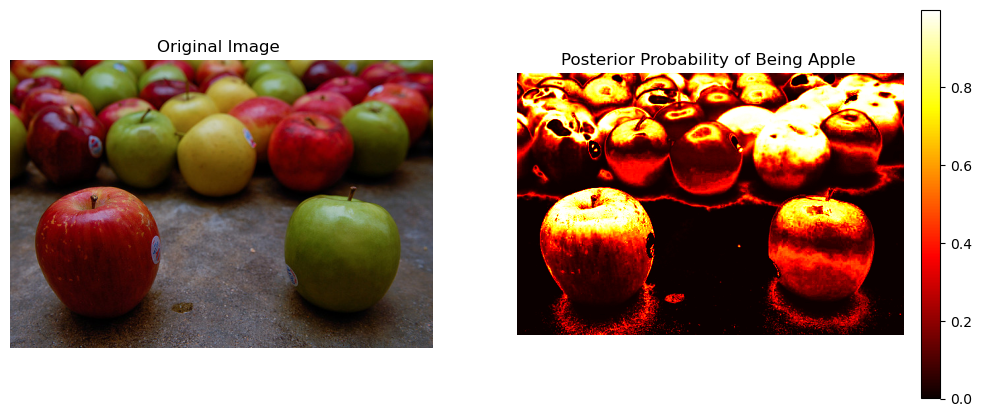

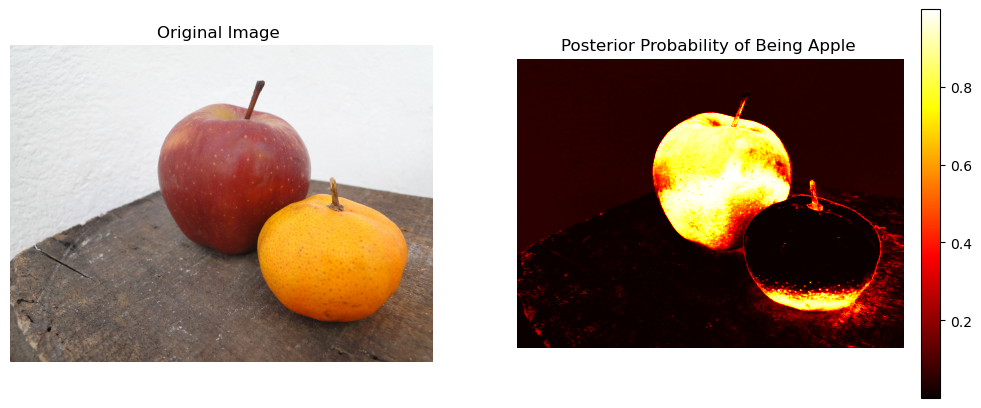

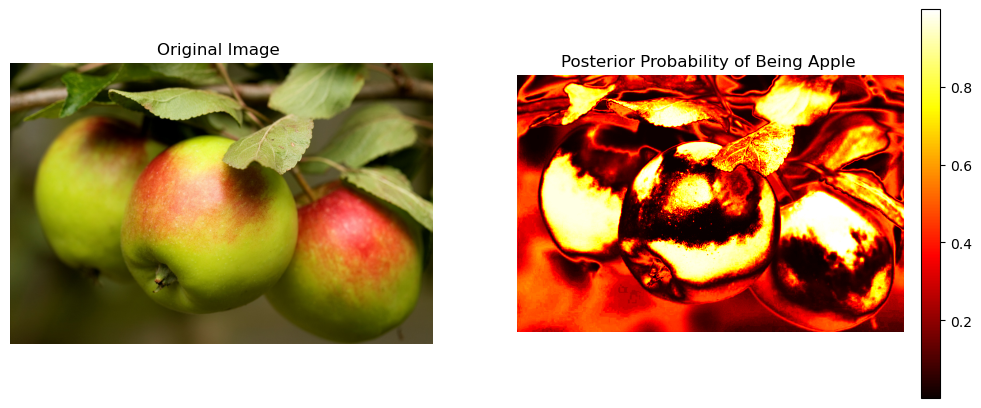

In [7]:
test_image_paths = ["testApples/Apples_by_MSR_MikeRyan_flickr.jpg", "testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg", "testApples/audioworm-QKUJj2wmxuI-original.jpg"]

for i in range(len(test_image_paths)):
    test_image = plt.imread(test_image_paths[i])
    if test_image.dtype == np.uint8:
        test_image = test_image.astype(np.float32) / 255.0 
    elif test_image.max() > 1.0:
        test_image = test_image / 255.0

    posterior_map = predict_posterior(
        test_image,
        gmm_apple,
        gmm_non_apple,
        prior_apple=0.4,
        prior_non_apple=0.6
    )
    plot_posterior(posterior_map, image=test_image)

### Comments on this section: 

In this section, each of the colour images are plotted next to the model's posterior probability of being apple image. Overall, we notice a decent performance, where apples are recieving most of the probability density. However, the model currently seems to be struggling on two fronts: 
The first is the shadows on the apples. This is quite evident when looking at all three pictures. In the first, the parts of the apples in the shadow seem to have a lower probability of being apple. The shadow of the orange in the second picture has a highr probability of being apple, and finally in the last picture, we see that the shadow of the leaf of the apple has a very low probability attributed to it, which reinforces my point. 
The second struggle is the variation in colour for the fruits. This can be seen in the first and last pictures. In the first, we see that the model seems to favour red apples, with the close one to the left having a greater probability than the one to the right. While these three examples aren't enought make any precise observations on the model, this shows us there might be biases in the model from the training data, and adding more training examples could help the performance of the model. 

# Section D: 

In [8]:
def calculate_ROC_curve(posterior, mask, threshold_size=0.01):
    """
    This function computes the ROC curve data points based on varying thresholds

    INPUT:
    posterior       : Numpy array containing the flattened posterior probability map
    mask            : Numpy array containing the ground truth binary mask
    threshold_size  : Float step size for thresholding between 0 and 1

    OUTPUT:
    false_positive_rate : List of False Positive Rates 
    true_positive_rate  : List of True Positive Rates
    """
    threshold = np.arange(0, 1 + threshold_size, threshold_size) 
    false_positive_rates = []  
    true_positive_rates = []  

    for i in threshold:
        true_positive = np.sum((mask == 1) & (posterior >= i))
        true_negative = np.sum((mask == 0) & (posterior < i))
        false_positive = np.sum((mask == 0) & (posterior >= i))
        false_negative = np.sum((mask == 1) & (posterior < i))

        if (false_positive + true_negative) == 0:
            fpr = 0
        else:
            fpr = false_positive / (false_positive + true_negative)

        if (true_positive + false_negative) == 0:
            tpr = 0
        else:
            tpr = true_positive / (true_positive + false_negative)

        false_positive_rates.append(fpr)
        true_positive_rates.append(tpr)

    return false_positive_rates, true_positive_rates


def compute_auc(false_positive_rate, true_positive_rate):
    """
    This function computes the Area Under the ROC Curve (AUC) using the trapezoidal rule

    INPUT:
    false_positive_rate        : List of False Positive Rates 
    true_positive_rate         : List of True Positive Rates

    OUtrue_positiveUT:
    auc_score                  : Float representing the AUC value
    """
    # We sort false_positive_rate and true_positive_rate based on false_positive_rate
    sorted_indices = np.argsort(false_positive_rate)
    false_positive_rate_sorted = np.array(false_positive_rate)[sorted_indices]
    true_positive_rate_sorted = np.array(true_positive_rate)[sorted_indices]

    # We compute the AUC using the trapezoidal rule
    auc_score = np.trapz(true_positive_rate_sorted, false_positive_rate_sorted)

    return auc_score

def plot_ROC(false_positive_rate, true_positive_rate, auc_score, plot_title='ROC Curve'):
    """
    This function plots the ROC curve

    INPUT:
    false_positive_rate            : List of False Positive Rates 
    true_positive_rate             : List of True Positive Rates
    auc_score                      : Float representing the AUC value
    plot_title                     : String title for the ROC plot
    """
    plt.figure(figsize=(8, 6))
    plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(plot_title, fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

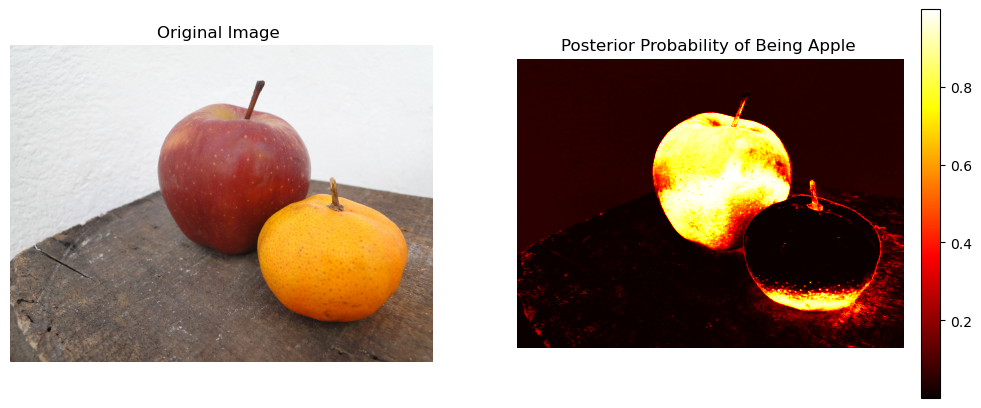

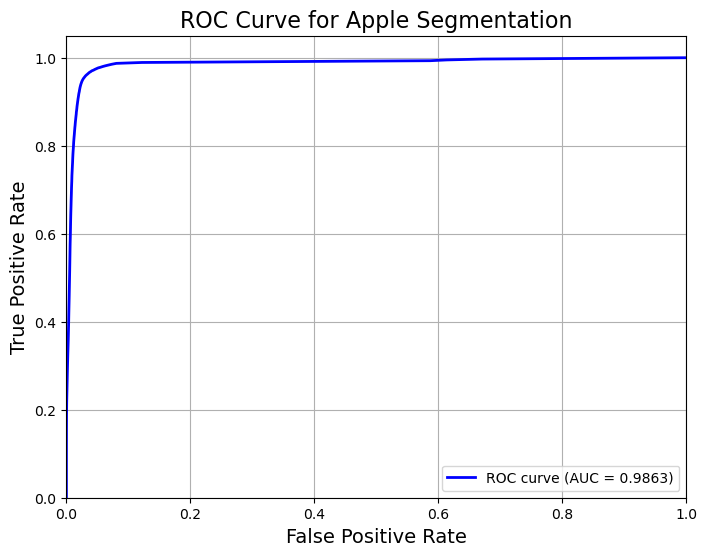

Area Under the ROC Curve (AUC): 0.9863


In [9]:
# We define the paths to our test image and the corresponding mask
test_image_path = "testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg"
test_mask_path = "testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png" 

test_image = plt.imread(test_image_path)
if test_image.dtype == np.uint8:
    test_image = test_image.astype(np.float32) / 255.0  
elif test_image.max() > 1.0:
    test_image = test_image / 255.0 

posterior_map = predict_posterior(
    test_image,
    gmm_apple,
    gmm_non_apple,
    prior_apple=0.4,
    prior_non_apple=0.6
)

plot_posterior(posterior_map, image=test_image)

ground_truth = load_ground_truth_mask(test_mask_path)

posterior_flat = posterior_map.flatten()
ground_truth_flat = ground_truth.flatten()

FPR, TPR = calculate_ROC_curve(posterior_flat, ground_truth_flat)
auc_score = compute_auc(FPR, TPR)

plot_ROC(FPR, TPR, auc_score, plot_title='ROC Curve for Apple Segmentation')
print(f"Area Under the ROC Curve (AUC): {auc_score:.4f}")


### Comments on this section: 

In this section, I've implemented the ROC curve and displayed the area under the curve to evaluate the performance of the model. 

The ROC curve is a graphical representation of a classification model's performance and plots two metric: the True Positive Rate (TPR) (also called Recall), and the False Positive Rate (FPR). Thhey represent the proportion of actual positives correctly identified by the model and the proportion of actual negatives incorrectly classified as positive respectively. According to Wikipedia, the closer the curve is to the top-left corner, the better the model is performing. We see that our model is quite close to this corner and suggests a good classification. 


The AUC (area under the ROC curve) is a measure of the perfromance of the model at speerating the positive and negative classes (apples and non apples in our case). The closer the AUC is to 1, the better the model is (which makes sense when looking at the ideal ROC curve).

We had an AUC of around 0.98, which suggests a good classification from our model. 

# Section E: 

In [10]:
def plot_image_mask_posterior(color_image, ground_truth, posterior_map, title_suffix=""):
    """
    This function plots the Original Image, Ground Truth Mask, and Posterior Probability Map side by side.

    INPUT:
    color_image     : Numpy array containing the original color image
    ground_truth    : Numpy array containing the ground truth binary mask
    posterior_map   : NUmpy array containing the predicted posterior probability map
    title_suffix    : Title suffix to add to the plot titles 
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # This is fo the original Image
    axes[0].imshow(color_image)
    axes[0].set_title('Original Image ' + title_suffix)
    axes[0].axis('off')

    # This is for the ground Truth Mask
    axes[1].imshow(ground_truth, cmap='gray')
    axes[1].set_title('Ground Truth Mask ' + title_suffix)
    axes[1].axis('off')

    # This is for the Posterior Probability Map
    im = axes[2].imshow(posterior_map, cmap='hot')
    axes[2].set_title('Posterior Probability ' + title_suffix)
    axes[2].axis('off')

    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.show()


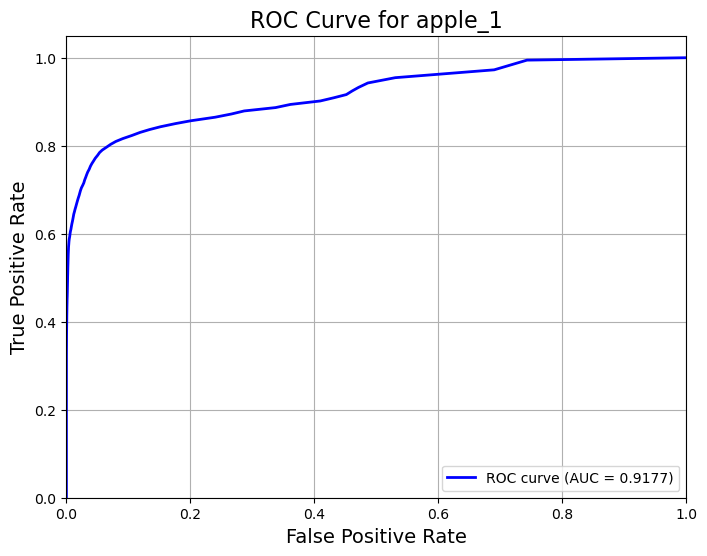

AUC for apple_1: 0.9177


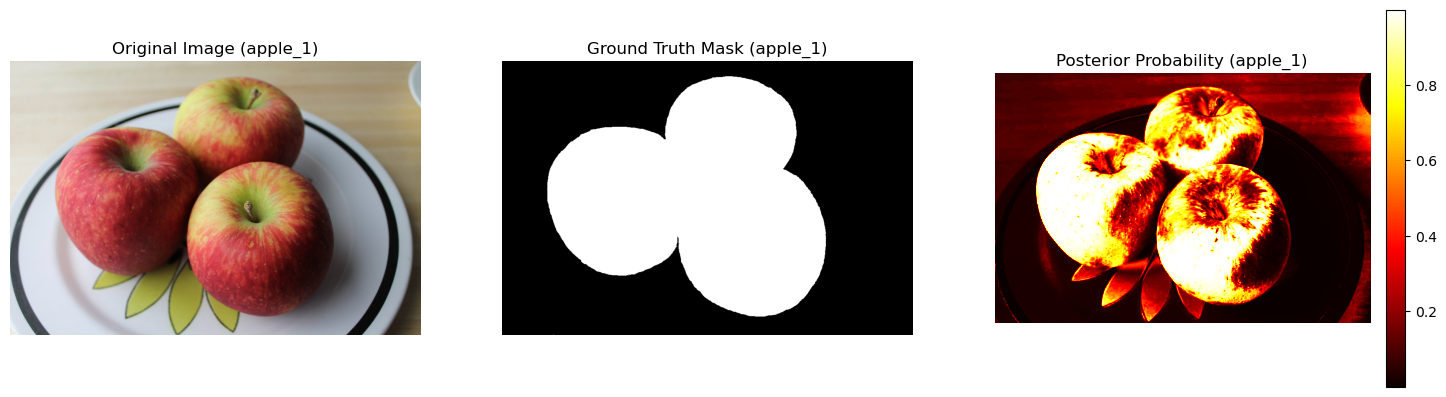

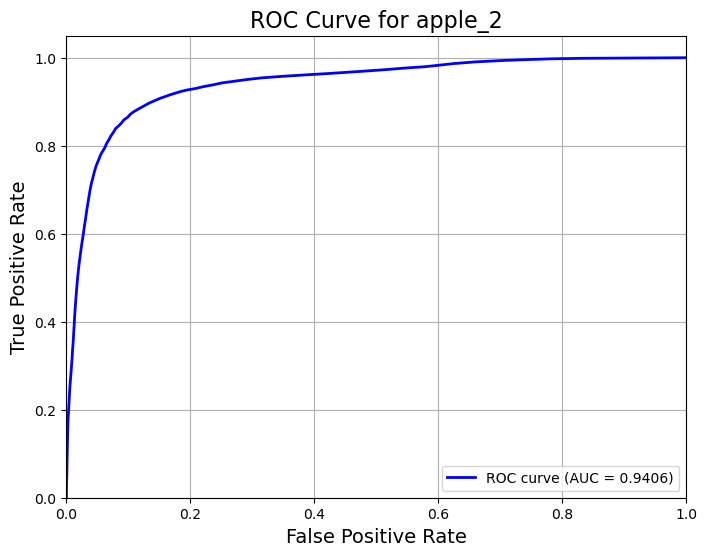

AUC for apple_2: 0.9406


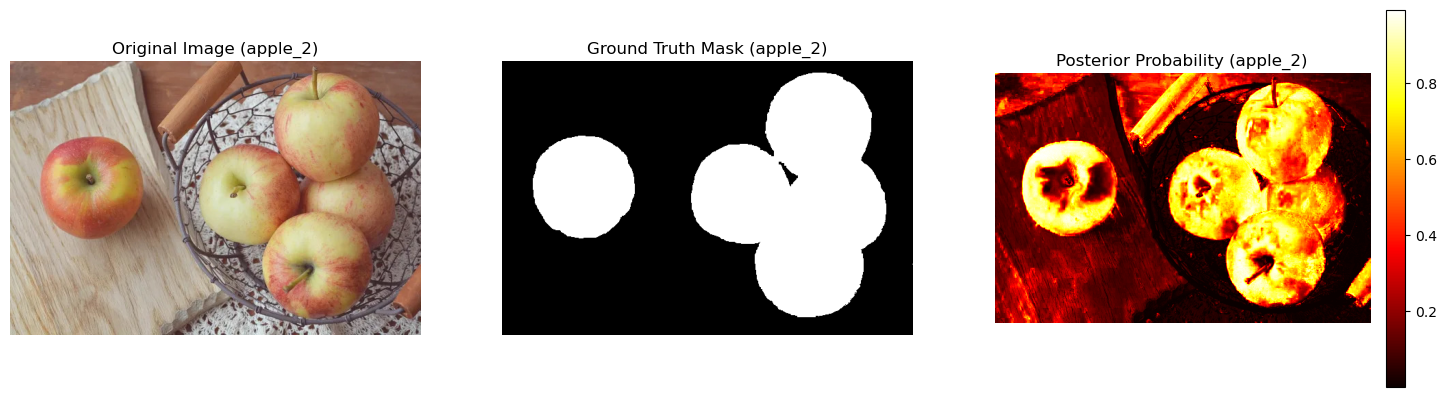

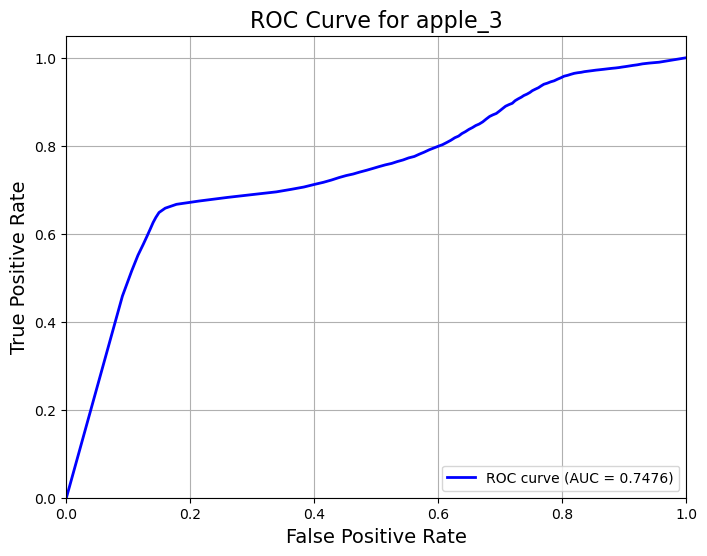

AUC for apple_3: 0.7476


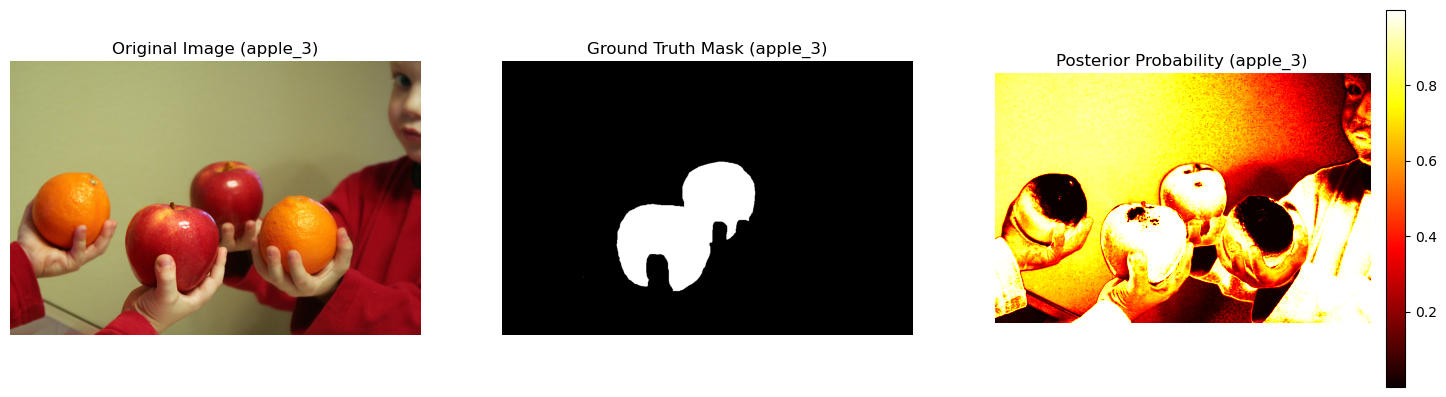

In [11]:
test_images_folder = "my_apple_images"
test_image_files = sorted(glob.glob(os.path.join(test_images_folder, "*.jpg")))
test_mask_files = sorted(glob.glob(os.path.join(test_images_folder, "*.png")))

auc_scores = []

for idx in range(3):
    test_image_path = test_image_files[idx]
    test_mask_path = test_mask_files[idx]

    base_name = os.path.basename(test_image_path).split('.')[0]

    test_image = plt.imread(test_image_path)
    if test_image.dtype == np.uint8:
        test_image = test_image.astype(np.float32) / 255.0 
    elif test_image.max() > 1.0:
        test_image = test_image / 255.0  

    posterior_map = predict_posterior(
        test_image,
        gmm_apple,
        gmm_non_apple,
        prior_apple=0.4,
        prior_non_apple=0.6
    )

    ground_truth = load_ground_truth_mask(test_mask_path)

    posterior_flat = posterior_map.flatten()
    ground_truth_flat = ground_truth.flatten()

    FPR, TPR = calculate_ROC_curve(posterior_flat, ground_truth_flat, threshold_size=0.01)

    auc_score = compute_auc(FPR, TPR)

    plot_ROC(FPR, TPR, auc_score, plot_title=f'ROC Curve for {base_name}')

    print(f"AUC for {base_name}: {auc_score:.4f}")
    auc_scores.append(auc_score)

    plot_image_mask_posterior(
            color_image=test_image,
            ground_truth=ground_truth,
            posterior_map=posterior_map,
            title_suffix=f"({base_name})"
        )



### Comments on this section: 

In this section, the ground truth masks are more accurate than the ones we used for training in section B and calculating the ROC curve and AUC in section D. 

The first two images show a AUC score of 0.93 and 0.94 (those numbers change slightly when the code is run again), which show that the model did a good job at claddifying the apples for those examples. It follows that the ROC curve seems closer to the top left corner of the graph. 
On the other hand, the third picture has a considerably lower AUC value of around 0.80. We can see qualitatively that this is due to the clothes of the children being attributed a very high probability. In all three examples, we see that the model struggles with shadows, whether projected on the ground by the apples or or the fruits themselves. I believe these issues could be fixed by adding more pictures to our training data set and maybe tuning the number of mixture components. 


# Section F: 

We should be using a train/test/val split as it allows us to have a much better idea of the actual model’s performance. The training set is the portion of the data on which the model learns and optimises its parameters. The validation set is used to find the best model hyperparameters, such as the learning rate, or number of mixture components in our case. This lets us find the best version of the model we can train. Finally, the test set is used to have an accurate representation of the model’s performance when confronted with unseen data. If we don’t separate these sets (use the training data as the test set), the model could memorise the data, leading to overfitting. So we should really be using the data split to have a model that we can generalise (prevent overfitting), as well as a reliable evaluation of the model. An example of the importance of this is shown in Section E, where the final picture had a much lower performance because the model mistook the clothes of the children for apples. The my_apple_images folder was the testing set for this exercise and allowed us to see a pitfall of the model that didn’t arise before. 